In [50]:
import pandas 
%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import feature_selection, preprocessing, linear_model, model_selection

plt.style.use('seaborn-deep')

In [51]:
# begin with the targets 

t = pandas.read_csv('../data_sets/speculative_targets.csv', index_col=0)

# I found that E164D was seriously outlier in
# some of the most-correlated features 
# so removing it 

t = t.drop(['E164D'], axis=0)

t.head()

,kcat,km,kcatkm,expression
mutant_name,,,,
S14A,-0.439333,0.217484,-0.651460,1
T15A,-0.156314,0.025306,-0.176657,1
S16A,-0.756962,0.447468,-1.199275,1
S17A,-0.016087,0.567026,-0.577999,1
S17E,-0.137625,0.165541,-0.298065,1


In [52]:
t.shape

(145, 4)

In [53]:
f = pandas.read_hdf('../feature_sets/bglb__enzyme_design.h5')
for feature in f:
    if f[feature].std() == 0.0:
        f.drop(feature, axis=1, inplace=True)
scaler = preprocessing.StandardScaler()
f = pandas.DataFrame(scaler.fit_transform(f), columns=f.columns, index=f.index)
f.shape

(7967, 52)

In [54]:
f.head()

,total_score,fa_rep,hbond_sc,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,tot_hbond_pm,tot_NLconts_pm,tot_nlsurfaceE_pm,tot_total_charge,...,SR_4_pstat_pm,SR_4_nlpstat_pm,SR_5_total_score,SR_5_fa_rep,SR_5_hbond_sc,SR_5_all_cst,SR_5_interf_E_1_2,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm
N1A,-0.479693,-0.417646,-0.546276,2.030579,1.719945,-0.499857,0.649158,0.501668,1.246296,-0.092074,...,0.896101,0.795424,-0.401840,-0.407716,-0.097690,-0.248647,-0.407670,-0.549353,1.400013,-0.215337
N1C,-0.473516,-0.419991,-0.157913,1.834224,1.719945,-0.499857,0.359736,0.755430,-0.178649,-0.092074,...,-0.626257,-1.116040,-1.206252,-0.338407,0.142902,-0.332486,-1.209815,-1.214754,0.633365,-0.215337
N1D,-0.477528,-0.418966,-0.416821,0.656095,0.582310,0.148023,0.070315,1.009192,-0.344403,-1.580020,...,0.852605,0.293665,-0.199575,-0.280650,-0.168774,-0.258028,-0.203065,-0.682433,-0.644381,-0.215337
N1E,-0.428130,-0.419762,-0.758110,-0.522035,-0.100272,-0.553847,0.938580,0.565109,0.291877,-1.580020,...,0.482889,1.010464,-1.164404,-0.307604,-1.180353,-0.389356,-1.162151,-0.549353,0.888914,-0.215337
N1F,-0.471979,-0.421643,-1.006034,0.459740,0.354782,-0.175917,0.576803,0.882311,1.345213,-0.092074,...,2.461954,1.416650,-1.157430,-0.723455,-0.447641,-0.476712,-1.155176,-0.150112,0.888914,-0.215337


/Users/alex/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/alex/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


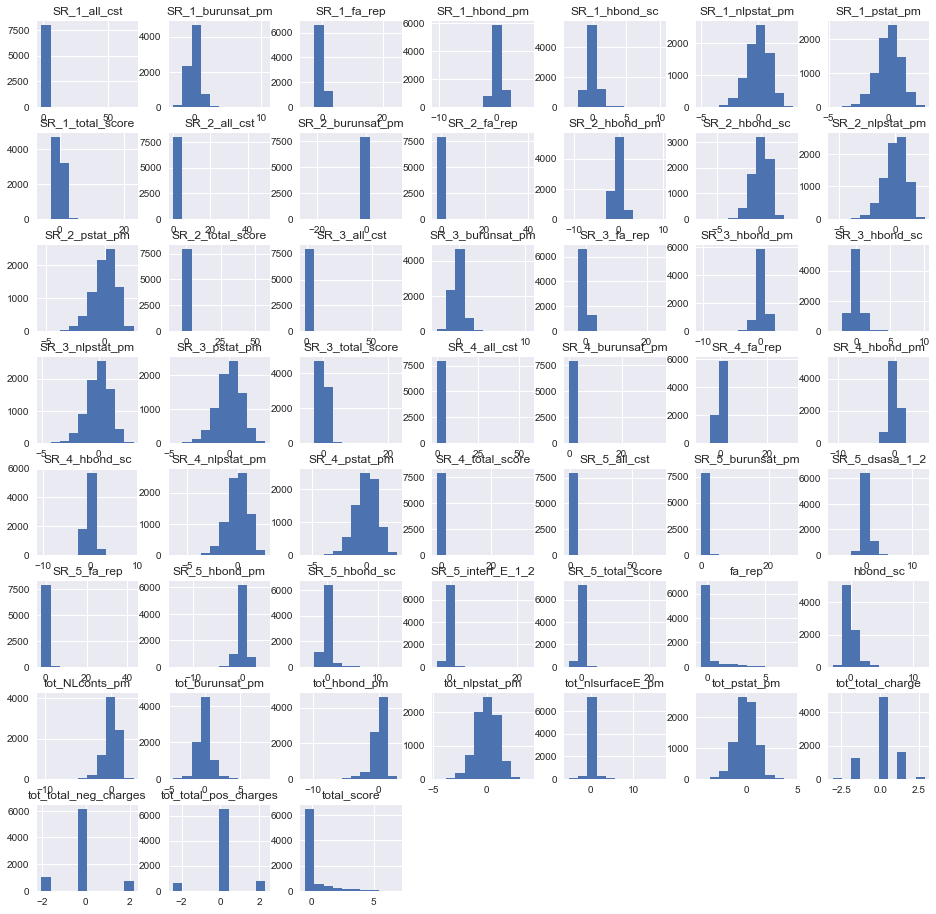

In [55]:
fig, ax = plt.subplots(ncols=1, figsize=(16,16))
f.hist(ax=ax)
fig.show()

In [56]:
def get_wanted():
    for i in t.index:
        if i not in f.index:
            print(i, 'not in index f.index')
        else:
            yield i
            
wanted = list(get_wanted())

BglB not in index f.index
A227W not in index f.index
E353E not in index f.index
E164G not in index f.index


In [57]:
for w in wanted:
    if w not in f.index:
        print(w, 'not in f.index')

In [62]:
print(t.loc[wanted].shape) # shape with expression and some missing kcat, km
df = t.loc[wanted].join(f).dropna() # gets only ones with full kinetics kcat/km

(151, 4)


In [63]:
# lets do the regular descriptive statistics here 

df.describe()

,kcat,km,kcatkm,expression,total_score,fa_rep,hbond_sc,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,...,SR_4_pstat_pm,SR_4_nlpstat_pm,SR_5_total_score,SR_5_fa_rep,SR_5_hbond_sc,SR_5_all_cst,SR_5_interf_E_1_2,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm
count,115.000000,115.000000,115.000000,115.0,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,...,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,-0.733169,0.163819,-0.906953,1.0,-0.430481,-0.394701,-0.045634,-0.151664,-0.095216,-0.144710,...,-0.169539,-0.051738,0.027431,-0.065037,0.001195,0.007016,0.027326,-0.098455,-0.063531,0.184981
std,0.826077,0.423044,1.052622,0.0,0.209458,0.114931,0.938122,0.915769,0.929100,1.004946,...,1.017914,0.987583,1.202961,0.428135,1.383840,0.322300,1.203068,2.082488,1.541348,1.700997
min,-3.643453,-1.096910,-4.044650,1.0,-0.482940,-0.435246,-1.592109,-3.074650,-2.830598,-1.687637,...,-3.344753,-2.382385,-3.789205,-1.266373,-2.766072,-0.715330,-3.788303,-6.464028,-13.166294,-0.215337
25%,-1.327528,-0.058499,-1.444464,1.0,-0.477176,-0.421869,-0.607429,-0.718390,-0.555326,-0.769807,...,-0.876359,-0.662067,-0.523510,-0.348034,-0.570671,-0.249494,-0.524181,-0.756366,-0.388832,-0.215337
50%,-0.439333,0.093422,-0.577522,1.0,-0.473696,-0.419393,-0.320319,-0.129325,0.127255,-0.337887,...,-0.104306,-0.040841,0.067787,-0.061173,-0.059414,0.041565,0.067804,-0.150112,-0.069395,-0.215337
75%,-0.119057,0.362180,-0.156182,1.0,-0.469021,-0.417375,0.287724,0.459740,0.531748,0.336988,...,0.417645,0.484811,0.492080,0.139052,0.208518,0.206604,0.493289,0.781449,0.633365,-0.215337
max,1.097344,1.814514,0.955350,1.0,1.063536,0.485185,3.461314,2.815999,2.402527,3.657372,...,2.026995,2.205129,7.563231,2.087394,11.855351,0.741590,7.564949,7.102758,3.444407,14.796596


In [ ]:
feature_names = df.columns[4:]
target_names = df.columns[0:3]

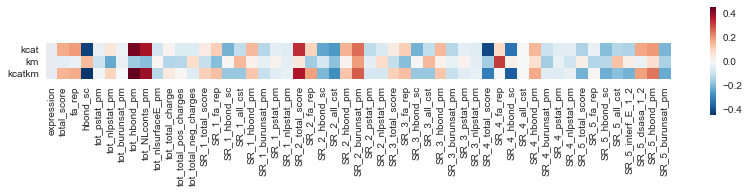

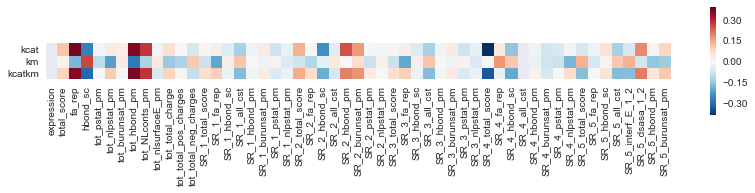

In [76]:
corr_p = df.corr(method='pearson')[target_names].drop(target_names, axis=0).T
fig, ax = plt.subplots(figsize=(14,2))
sns.heatmap(corr_p, square=1, ax=ax)

corr_s = df.corr(method='spearman')[target_names].drop(target_names, axis=0).T
fig, ax = plt.subplots(figsize=(14,2))
sns.heatmap(corr_s, square=1, ax=ax)

**Correlations between individual Rosetta energy metrics and measured kinetic constants for 115 BglB mutants.** A) Pearson correlation between individual Rosetta energy metrics (given by short name) and measured kinetic constants. B) Spearman correlation ... kinetic constants.  

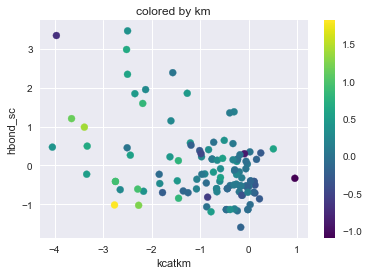

In [79]:
feature = 'hbond_sc'
plt.scatter(df.kcatkm, df[feature], c=df.km, cmap='viridis')
plt.colorbar()
plt.title('colored by km')
plt.xlabel('kcatkm')
plt.ylabel(feature)

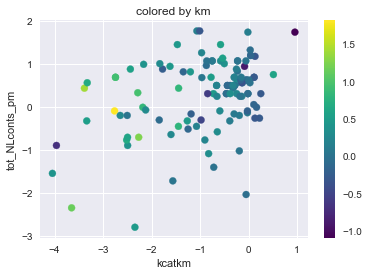

In [80]:
feature = 'tot_NLconts_pm'
plt.scatter(df.kcatkm, df[feature], c=df.km, cmap='viridis')
plt.colorbar()
plt.title('colored by km')
plt.xlabel('kcatkm')
plt.ylabel(feature)

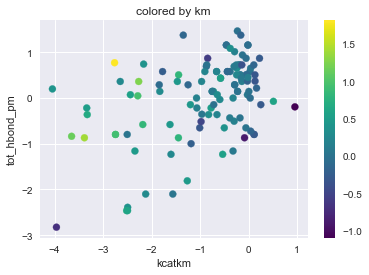

In [81]:
feature = 'tot_hbond_pm'
plt.scatter(df.kcatkm, df[feature], c=df.km, cmap='viridis')
plt.colorbar()
plt.title('colored by km')
plt.xlabel('kcatkm')
plt.ylabel(feature)

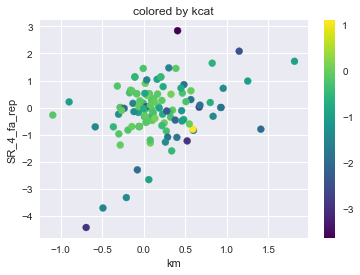

In [82]:
feature = 'SR_4_fa_rep'
plt.scatter(df.km, df[feature], c=df.kcat, cmap='viridis')
plt.colorbar()
plt.title('colored by kcat')
plt.xlabel('km')
plt.ylabel(feature)

In [24]:
#df.query('tot_hbond_pm<408')
# used this to find that E164D was the outlier 

In [137]:
len(feature_names)

52

In [139]:
result = {}
for target in target_names:
    X = df[feature_names]
    y = df[target]
#     clf = linear_model.ElasticNetCV(l1_ratio=[0.6, 0.9], max_iter=5e4, cv=10)
    clf = linear_model.SGDRegressor(loss='epsilon_insensitive', penalty='elasticnet')
    pred = model_selection.cross_val_predict(clf, X, y, cv=10)
    clf.fit(X, y)
#     pred = clf.fit(X, y).predict(X)
    result.update({target: {'pred': pred, 'y': y, 'clf': clf}})

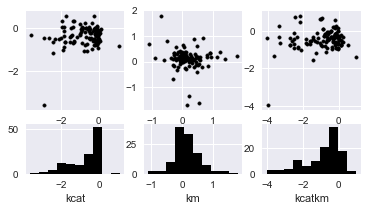

In [140]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(6, 3), gridspec_kw={'height_ratios': (2,1)})
for n, target in enumerate(target_names):
    dat = result[target]
    ax[0, n].scatter(dat['y'], dat['pred'], marker='.', color='k')
    ax[1, n].hist(dat['y'], color='k') 
    ax[1, n].set(xlabel=target)

In [195]:
names = pandas.read_csv('../data_sets/names.csv', index_col=0).T
names.index = list(range(1, 11)) + [0]
names

0,P22505_16,Q7MG41_142,Q97AX4_139,Q59976_4
1,R240A,S246R,A281R,I241R
2,E222A,T230E,T264E,H223E
3,Y295W,Y298W,Y315W,Y295W
4,Q19A,Q27A,Q20A,Q18A
5,W325A,W326A,W354A,W342A
6,W120F,W128F,W150F,W120F
7,Y118F,Y126F,Y148F,Y118F
8,N293Q,N296Q,N313Q,N293Q
9,T352V,T353V,T379V,T368V
10,N220Y,N223Y,A262Y,N221Y


In [196]:
names1 = ['BglB', 'run_A', 'run_B', 'run_C']
names2 = ['P22505_16', 'Q7MG41_142', 'Q97AX4_139', 'Q59976_4']
names_map = dict(zip(names1, names2))
names_map

{'BglB': 'P22505_16',
 'run_A': 'Q7MG41_142',
 'run_B': 'Q97AX4_139',
 'run_C': 'Q59976_4'}

In [205]:
# let's annotate this 
family_data = pandas.read_csv('../data_sets/family_data_set.csv')
family_data = family_data[(family_data.rel_or_abs == 'rel')]
family_data['run'] = family_data['scaffold'].map(dict(zip(names2, names1)))
mutant_names = []
for idx, row in family_data.iterrows():
    pkg = names[row.scaffold]
    mutant_names.append(pkg[row.mutant_name_index])
family_data['mutant_name'] = mutant_names
family_data.drop(['rel_or_abs'], axis=1, inplace=True)
family_data.sample(5)

,value,mutant_name_index,kinetic_constant,scaffold,run,mutant_name
144,-2.747329,4,kcat,Q7MG41_142,run_A,Q27A
199,0.000000,0,km,P22505_16,BglB,WT
221,0.031152,7,kcatkm,P22505_16,BglB,Y118F
70,-0.226396,1,km,Q97AX4_139,run_B,A281R
69,0.149617,1,kcat,Q97AX4_139,run_B,A281R


In [187]:
#! cp ../feature_sets/run_A__enzyme_design.h5 ../feature_sets/run_C__enzyme_design.h5

KeyError: 'the label [P22505_16] is not in the [index]'

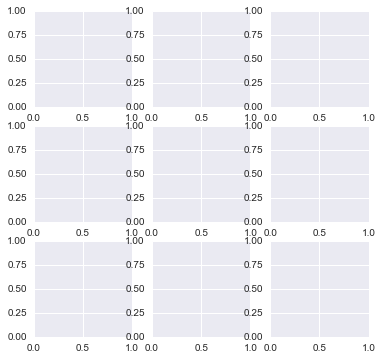

In [206]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))
for n, target in enumerate(target_names):
    clf = result[target]['clf']
    for m, (k, v) in enumerate(names_map.items()):
        f = pandas.read_hdf('../feature_sets/{}__enzyme_design.h5'.format(k))
        for feature in f:
            if f[feature].std() == 0.0:
                f.drop(feature, axis=1, inplace=True)
        scaler = preprocessing.StandardScaler()
        f = pandas.DataFrame(scaler.fit_transform(f), columns=f.columns, index=f.index)
        mutants = names.loc[v]
        r = f.loc[mutants].dropna()
        fd = family_data[(family_data.scaffold == v)&(family_data.kinetic_constant==target)].set_index('mutant_name_index')
        r['pred'] = clf.predict(r)
        r['scaffold'] = v
#         r['mutant_name'] = 
        print(r.shape)

In [158]:
family_data = pandas.read_csv('../data_sets/family_data_set.csv')
family_data

,value,mutant_name_index,kinetic_constant,rel_or_abs,scaffold
0,0.000000,0,kcat,rel,Q59976_4
1,0.000000,0,km,rel,Q59976_4
2,0.000000,0,kcatkm,rel,Q59976_4
3,0.286449,1,kcat,rel,Q59976_4
4,-2.528274,1,km,rel,Q59976_4
5,-2.241825,1,kcatkm,rel,Q59976_4
6,-2.349035,2,kcat,rel,Q59976_4
7,-2.665112,2,km,rel,Q59976_4
8,-5.014146,2,kcatkm,rel,Q59976_4
9,-3.252125,3,kcat,rel,Q59976_4


In [ ]:
# run A 

target_name = 'Q7MG41_142'
constants = 'kcat km kcatkm'.split()
p = pandas.read_hdf('../feature_sets/run_A__enzyme_design.h5')

# run it 
for constant in constants: 
    mut_names = [n for n in list(names.T[target_name]) if n != 'WT']
    mut_feats = p.loc[mut_names].dropna()
    grid = grids[target_name] # dict of fitted clfs 
    pred = grid.predict(mut_feats)
    pred_map = dict(zip(mut_feats.index, pred))
    my_series = names.T[target_name]
    my_series.index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0]
    data = pandas.read_csv('../data_sets/family_data_set.csv')
    s = data[(data.scaffold == target_name) & (data.kinetic_constant == constant) & (data.rel_or_abs == 'rel')].copy()
    s['mutant'] = s.mutant_name_index.map(my_series)
    s['prediction'] = s.mutant.map(pred_map)
    plt.scatter(s.value, s.prediction)
    plt.xlabel('Experimental {}, log10(mutant/native)'.format(constant))
    plt.ylabel('Blind prediction trained on BglB data set')

,1,2,3,4,5,6,7,8,9,10,0.1
BglB,R240A,E222A,Y295W,Q19A,W325A,W120F,Y118F,N293Q,T352V,N220Y,WT
run_A,S246R,T230E,Y298W,Q27A,W326A,W128F,Y126F,N296Q,T353V,N223Y,WT
run_B,A281R,T264E,Y315W,Q20A,W354A,W150F,Y148F,N313Q,T379V,A262Y,WT
run_C,I241R,H223E,Y295W,Q18A,W342A,W120F,Y118F,N293Q,T368V,N221Y,WT


In [45]:
mut_feats = p.loc[mut_names].dropna()
mut_feats

,total_score,fa_rep,hbond_sc,all_cst,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,tot_hbond_pm,tot_NLconts_pm,tot_nlsurfaceE_pm,...,SR_4_nlpstat_pm,SR_5,SR_5_total_score,SR_5_fa_rep,SR_5_hbond_sc,SR_5_all_cst,SR_5_interf_E_1_2,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm
S246R,-2549.285,385.147000,-85.546000,0.0,0.579000,0.575000,167.200000,410.500000,212.700000,11.743000,...,0.736000,450.0,-9.399000,1.761000,-3.090000,0.148,-14.796000,0.879000,7.100000,0.0
T230E,-2541.037,384.865000,-83.178000,0.0,0.577000,0.581000,167.000000,409.800000,215.300000,11.747000,...,0.672000,450.0,-9.456000,1.814000,-3.074000,0.122,-14.912000,0.889000,6.900000,0.0
Q27A,-2541.818,384.041000,-80.778000,0.0,0.576000,0.574000,165.800000,404.800000,213.900000,11.750000,...,0.647000,450.0,-8.592000,1.941000,-2.159000,0.180,-13.183000,0.875000,4.700000,0.0
W326A,-2535.374,384.680000,-83.137000,0.0,0.582000,0.572000,164.500000,408.100000,210.500000,11.740000,...,0.674000,450.0,-8.327000,1.827000,-3.078000,0.146,-12.654000,0.826000,6.600000,0.0
W128F,-2538.192,387.236000,-83.591000,0.0,0.578000,0.570000,166.200000,407.800000,213.300000,11.747000,...,0.664000,450.0,-8.644000,1.794000,-2.781000,0.194,-13.287000,0.886000,5.900000,0.0
Y126F,-2539.657,386.061000,-83.946000,0.0,0.580000,0.574000,166.200000,408.500000,214.700000,11.750000,...,0.768000,450.0,-9.280000,1.887000,-3.120000,0.170,-14.558000,0.877000,6.800000,0.0
N296Q,-2531.776,391.693000,-82.854000,0.0,0.582000,0.579000,168.400000,408.200000,213.100000,11.746000,...,0.790000,450.0,-8.480000,2.040000,-2.856000,1.540,-12.960000,0.877000,6.900000,0.0
T353V,-2531.100,388.541429,-83.005714,0.0,0.584286,0.578571,168.428571,408.428571,212.714286,11.744286,...,0.791429,450.0,-9.255714,1.815714,-2.998571,0.160,-14.507143,0.878571,6.428571,0.0


In [46]:
pred2 = grid.predict(mut_feats)
pred2

array([-7.10332423, -6.63318438, -8.27160036, -8.88525165, -7.77940681,
       -7.32758126, -7.64516819, -7.5975112 ])

In [47]:
pred_map = dict(zip(mut_feats.index, pred2))
pred_map

{'N296Q': -7.6451681942455956,
 'Q27A': -8.2716003582883673,
 'S246R': -7.1033242326708841,
 'T230E': -6.6331843837614795,
 'T353V': -7.5975111994551492,
 'W128F': -7.7794068061469952,
 'W326A': -8.8852516526813172,
 'Y126F': -7.3275812579190536}

In [48]:
my_series = names.T['Q7MG41_142']
my_series.index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0]

# get the actual values 
data = pandas.read_csv('../data_sets/family_data_set.csv')
s = data[(data.scaffold == 'Q7MG41_142') & (data.kinetic_constant == 'km') & (data.rel_or_abs == 'rel')].copy()
s['mutant'] = s.mutant_name_index.map(my_series)
s['prediction'] = s.mutant.map(pred_map)
s

,value,mutant_name_index,kinetic_constant,rel_or_abs,scaffold,mutant,prediction
133,0.000000,0,km,rel,Q7MG41_142,WT,NaN
136,0.000000,1,km,rel,Q7MG41_142,S246R,-7.103324
139,-0.301030,2,km,rel,Q7MG41_142,T230E,-6.633184
142,-0.477121,3,km,rel,Q7MG41_142,Y298W,NaN
145,-1.327359,4,km,rel,Q7MG41_142,Q27A,-8.271600
148,-1.834103,5,km,rel,Q7MG41_142,W326A,-8.885252
151,-1.088136,6,km,rel,Q7MG41_142,W128F,-7.779407
154,-0.096910,7,km,rel,Q7MG41_142,Y126F,-7.327581
157,-0.778151,8,km,rel,Q7MG41_142,N296Q,-7.645168
160,-0.477121,9,km,rel,Q7MG41_142,T353V,-7.597511


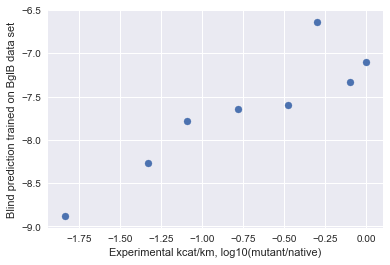

In [49]:
plt.scatter(s.value, s.prediction)
plt.xlabel('Experimental kcat/km, log10(mutant/native)')
plt.ylabel('Blind prediction trained on BglB data set')

In [ ]:
# run A 

target_name = 'Q7MG41_142'
constants = 'kcat km kcatkm'.split()
p = pandas.read_hdf('../feature_sets/run_A__enzyme_design.h5')

# run it 
for constant in constants: 
    mut_names = [n for n in list(names.T[target_name]) if n != 'WT']
    mut_feats = p.loc[mut_names].dropna()
    grid = grids[target_name] # dict of fitted clfs 
    pred = grid.predict(mut_feats)
    pred_map = dict(zip(mut_feats.index, pred))
    my_series = names.T[target_name]
    my_series.index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0]
    data = pandas.read_csv('../data_sets/family_data_set.csv')
    s = data[(data.scaffold == target_name) & (data.kinetic_constant == constant) & (data.rel_or_abs == 'rel')].copy()
    s['mutant'] = s.mutant_name_index.map(my_series)
    s['prediction'] = s.mutant.map(pred_map)
    plt.scatter(s.value, s.prediction)
    plt.xlabel('Experimental {}, log10(mutant/native)'.format(constant))
    plt.ylabel('Blind prediction trained on BglB data set')

       value  mutant_name_index kinetic_constant rel_or_abs    scaffold  \
66  0.000000                  0             kcat        rel  Q97AX4_139   
69  0.149617                  1             kcat        rel  Q97AX4_139   
72 -1.618422                  2             kcat        rel  Q97AX4_139   
75 -1.578913                  3             kcat        rel  Q97AX4_139   
78 -2.338581                  4             kcat        rel  Q97AX4_139   
81 -0.245816                  5             kcat        rel  Q97AX4_139   
84  0.125125                  6             kcat        rel  Q97AX4_139   
87 -0.049801                  7             kcat        rel  Q97AX4_139   
90 -0.717275                  8             kcat        rel  Q97AX4_139   
93 -0.147025                  9             kcat        rel  Q97AX4_139   
96 -0.203647                 10             kcat        rel  Q97AX4_139   

   mutant  prediction  
66     WT         NaN  
69  A281R  -22.349972  
72  T264E  -21.520124  
75 

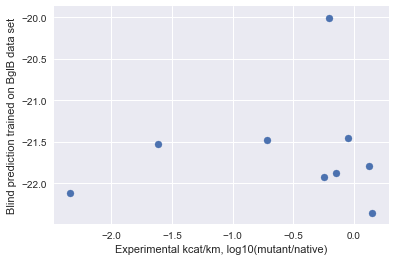

In [51]:
# now, for run B 

target_name = 'Q97AX4_139'
constant = 'kcat'

p = pandas.read_hdf('../feature_sets/run_B__enzyme_design.h5')
mut_names = [n for n in list(names.T[target_name]) if n != 'WT']
mut_feats = p.loc[mut_names].dropna()
pred = grid.predict(mut_feats)
pred_map = dict(zip(mut_feats.index, pred))
my_series = names.T[target_name]
my_series.index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0]

# get the actual values 
data = pandas.read_csv('../data_sets/family_data_set.csv')
s = data[(data.scaffold == target_name) & (data.kinetic_constant == constant) & (data.rel_or_abs == 'rel')].copy()
s['mutant'] = s.mutant_name_index.map(my_series)
s['prediction'] = s.mutant.map(pred_map)
print(s)
plt.scatter(s.value, s.prediction)
plt.xlabel('Experimental kcat/km, log10(mutant/native)')
plt.ylabel('Blind prediction trained on BglB data set')

In [ ]:
# OK, repeat above for all combos 